<a href="https://colab.research.google.com/github/sol-sun/Generative_Deep_Learning_2nd_Pytorch/blob/main/06_normflow/realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌀 RealNVP

本ノートブックでは，RealNVP(real-valued non-volume preserving transformations)ネットワークの実装を行います．

In [1]:
!pip install datasets | tail -n 1
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1
!pip install onnx | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import os
import re
import string
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
from datasets import Dataset as HFDataset
import torchvision
import torch
import torchinfo
import random
import json
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, PretrainedConfig, PreTrainedModel, pipeline
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING_NAMES
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

def save_metrics(metrics_per_epoch, filename):
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # ファイルにメトリクスを保存
    with open(filename, "w") as f:
        json.dump(metrics_per_epoch, f, indent=2)

# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


## 0. パラメータ

In [4]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

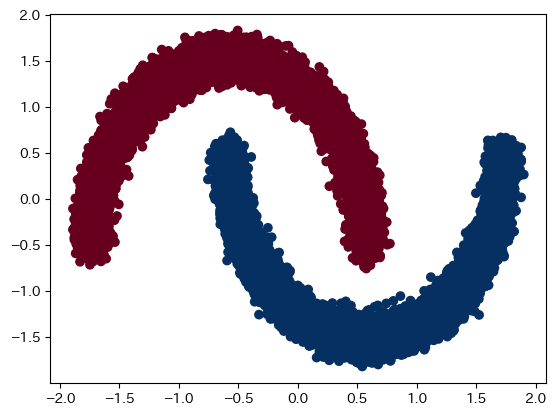

In [5]:
# データの読み込み
data, labels = datasets.make_moons(30000, noise=0.05)
data = data.astype(np.float32)

# 正規化（Normalizationの代わりにStandardScalerを使用）
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

trainset = torch.utils.data.TensorDataset(torch.from_numpy(normalized_data), torch.from_numpy(labels))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# 散布図の描画
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=labels, cmap="RdBu")
plt.show()

## 2. RealNVPモデルの構築

In [6]:
class Coupling(nn.Module):
    def __init__(self, input_dim=2, layers=5, coupling_dim=256):
        super().__init__()
        self.s_layers = nn.ModuleList([
            nn.Linear(input_dim, coupling_dim),
            *[nn.Linear(coupling_dim, coupling_dim) for _ in range(layers-2)],
            nn.Linear(coupling_dim, input_dim)
        ])

        self.t_layers = nn.ModuleList([
            nn.Linear(input_dim, coupling_dim),
            *[nn.Linear(coupling_dim, coupling_dim) for _ in range(layers-2)],
            nn.Linear(coupling_dim, input_dim)
        ])

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        s, t = x, x
        for i, layer in enumerate(self.s_layers):
            if i != len(self.s_layers) -1:
                s = self.relu(layer(s))
            else: # 最後の要素
                s = self.tanh(layer(s))

        for i, layer in enumerate(self.t_layers):
            if i != len(self.t_layers) -1:
                t = self.relu(layer(t))
            else: # 最後の要素
                t = layer(t)

        return s, t

In [7]:
class RealNVP(nn.Module):
  def __init__(self, coupling_layers=6, input_dim=2, coupling_dim=256, device='cpu'):
      super().__init__()
      self.coupling_layers = coupling_layers
      self.layer_list = nn.ModuleList([Coupling(input_dim, coupling_layers, coupling_dim)
      for _ in range(coupling_layers)])
      # 行方向に繰り返し
      self.masks = torch.tensor([[1., 0.], [0., 1.]], device=device).repeat(coupling_layers // 2, 1)
      # 潜在空間(ガウス分布): 平均0、標準偏差1の正規分布を定義
      self.distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(2, device=device),
                                                                  covariance_matrix=torch.eye(2, device=device))

  def forward(self, x):
    x = x.to(device)
    log_det_inv = 0

    if self.training:
        direction = 1
    else:
        direction = -1

    for i in range(self.coupling_layers)[::direction]:
        x_masked = x * self.masks[i]
        reversed_mask = 1 - self.masks[i]
        s, t = self.layer_list[i](x_masked)
        s = s* reversed_mask
        t = t* reversed_mask
        gate = (direction - 1) / 2
        x = (reversed_mask
            * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
            + x_masked)

        log_det_inv += (1 + gate) * torch.sum(s, dim=1)
    return x, log_det_inv

  def log_loss(self, x):
    y, logdet = self(x)
    # y が起こる対数確率（尤度）を取得
    log_likelihood = self.distribution.log_prob(y) + logdet
    return -torch.mean(log_likelihood)

In [8]:
model = RealNVP(coupling_layers=6, input_dim=2, coupling_dim=256, device=device)
model.eval()
torch_input = torch.randn(1, 2).to(device)
# ONNXにエクスポート（netronにアップすればモデルを可視化できる）
torch.onnx.export(
    model.to(device),
    torch_input,
    "RealNVP.onnx",
)

## 3. RealNVPモデルを訓練する

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
model = model.to(device)
model.train() # model.training = True
metrics_per_epoch = {
    "loss": [],
}
for epoch in range(EPOCHS):
    epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
    batch_count = 0

    for i, data in enumerate(trainloader, 0):
        xx, _ = data
        xx = xx.to(device)

        optimizer.zero_grad()

        loss = model.log_loss(xx)
        loss.backward()
        optimizer.step()

        for key in epoch_metrics:
            epoch_metrics[key] += loss.item()
        batch_count += 1
    for key in epoch_metrics:
        epoch_metrics[key] /= batch_count
        metrics_per_epoch[key].append(epoch_metrics[key])

    # epoch終了時点でのlossの平均値
    print("Epoch {}:".format(epoch + 1), epoch_metrics)

# modelを保存
save_path = f"./models/11_realnvp_model_epoch_{EPOCHS}.pth"

save_model(model, save_path)

# metricsを保存
metrics_save_path = f"./metrics/11_realnvp_metrics.json"
save_metrics(metrics_per_epoch=metrics_per_epoch, filename=metrics_save_path)

Epoch 1: {'loss': 2.4183684708708424}
Epoch 2: {'loss': 1.7451670695159396}
Epoch 3: {'loss': 1.4713242690441972}
Epoch 4: {'loss': 1.3544058385541884}
Epoch 5: {'loss': 1.3095447289741646}
Epoch 6: {'loss': 1.2955142300007707}
Epoch 7: {'loss': 1.2745755062264912}
Epoch 8: {'loss': 1.2624349058684656}
Epoch 9: {'loss': 1.2532509676480696}
Epoch 10: {'loss': 1.244906344656217}
Epoch 11: {'loss': 1.2436303870152619}
Epoch 12: {'loss': 1.246211463111942}
Epoch 13: {'loss': 1.2412763803692188}
Epoch 14: {'loss': 1.2261246836791604}
Epoch 15: {'loss': 1.230694299027071}
Epoch 16: {'loss': 1.2184837147340937}
Epoch 17: {'loss': 1.2252529910055256}
Epoch 18: {'loss': 1.2169292993464713}
Epoch 19: {'loss': 1.2176232024774714}
Epoch 20: {'loss': 1.2272488656690566}
Epoch 21: {'loss': 1.2156623228121612}
Epoch 22: {'loss': 1.2074180013042386}
Epoch 23: {'loss': 1.2094520330429077}
Epoch 24: {'loss': 1.205844689223726}
Epoch 25: {'loss': 1.2025404249207448}
Epoch 26: {'loss': 1.2106945060067258}

## 4. 潜在空間への変換の可視化

In [11]:
def plot_moons(xx, yy, ax):
    """Scatter plot xx and yy to matplotlib axis handle ax"""
    ax.scatter(xx[:,0], xx[:,1], c=yy, cmap="RdBu")

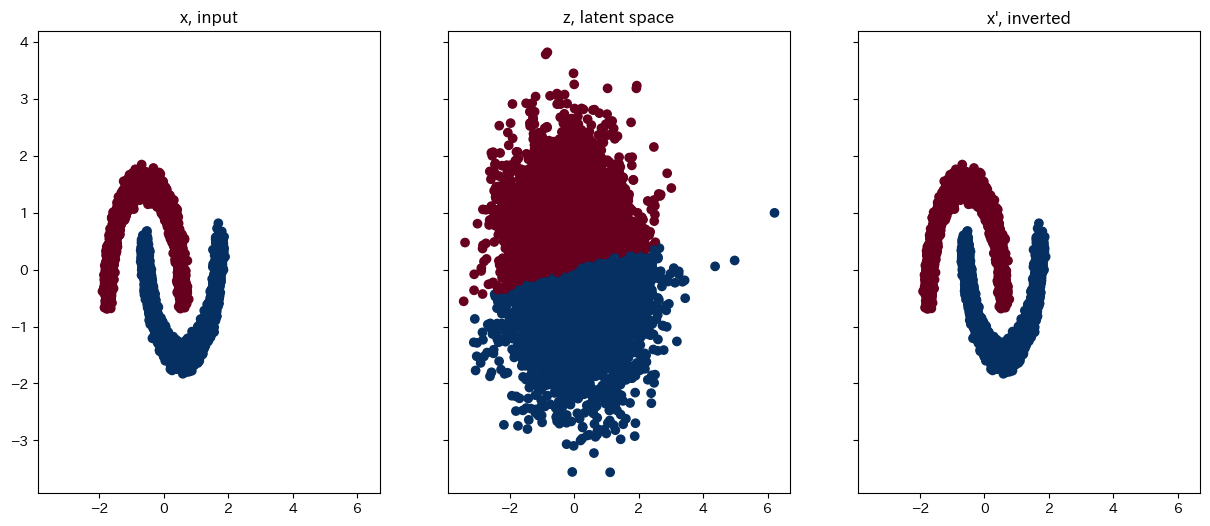

In [15]:
# map from input to latent space
model.eval() # model.training = False

# データの読み込み
data, y0 = datasets.make_moons(10000, noise=0.05)
data = data.astype(np.float32)

# 正規化（Normalizationの代わりにStandardScalerを使用）
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
x0 = torch.from_numpy(normalized_data)
x0 = x0.to(device).cpu()

# 潜在空間への変換
model.train()  # 順方向モード
with torch.no_grad():
    z, _ = model(x0)
    z = z.cpu().detach()

model.eval() # 逆方向モード
# map from latent back to input space
x1, _ = model(z)
x1 = x1.cpu().detach()

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(15,6))
plot_moons(x0, y0, ax[0])
plot_moons(z, y0, ax[1])
plot_moons(x1, y0, ax[2])

ax[0].set(title="x, input")
ax[1].set(title="z, latent space")
ax[2].set(title="x', inverted");